In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind

import ipywidgets as widgets
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5 # the ralative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = .5
plt.rcParams['legend.labelspacing'] = .4 # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = .5 # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# Размер выборки
Посмотрим, как ошибки первого и второго рода зависят от величины эффекта и дисперсии

In [3]:
x = np.linspace(-4, 6, 1001)
H0_dist = stats.norm()
H0_pdf = H0_dist.pdf(x)

def get_beta(alpha, H1_mean, H1_std=1.0, two_side=False):
    H0_dist = stats.norm()
    if two_side:
        alpha = alpha / 2

    right_bound = H0_dist.ppf(1 - alpha)
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    beta = H1_dist.cdf(right_bound)
    if two_side:
        beta -= H0_dist.cdf(-right_bound)
    return beta


def plot_first_second_type_errors(H1_mean, H1_std, alpha, two_side=True):
    H1_dist = stats.norm(loc=H1_mean, scale=H1_std)
    H1_pdf = H1_dist.pdf(x)
    plt.figure(figsize=(10, 5))
    plt.plot(x, H0_pdf, label='H0 distribution')
    plt.plot(x, H1_pdf, label='H1 distribution')

    beta = get_beta(alpha, H1_mean, H1_std, two_side=two_side)
    cr_bound = alpha / 2 if two_side else alpha
    x_left, x_right = H0_dist.ppf(cr_bound), H0_dist.ppf(1 - cr_bound)
    alpha_error_left = np.linspace(-4, x_left, 101)
    alpha_error_right = np.linspace(x_right, 6, 101)
    # beta_error = np.linspace(x_left, x_right, 101)
    if two_side:
        plt.fill_between(alpha_error_left, H1_dist.pdf(alpha_error_left), color='green', alpha=.25)
        plt.fill_between(alpha_error_left, H0_dist.pdf(alpha_error_left), color='red', alpha=.25)
    plt.fill_between(alpha_error_right, H1_dist.pdf(alpha_error_right), color='green', alpha=.25)
    plt.fill_between(alpha_error_right, H0_dist.pdf(alpha_error_right), color='red', alpha=.25)
    # plt.fill_between(beta_error, H1_dist.pdf(veta_error), color='yellow', alpha=.25)

    title = f'Критические области {"двухстороннего" if two_side else "одностороннего"} критерия'
    plt.title(title, size=16)
    plt.legend(loc=2, fontsize=14)
    annotation = f'alpha = {alpha:.3f}\npower = {1 - beta:.3f}'
    plt.text(-4.1, 0.26, annotation, size=18)
    plt.grid()
    plt.savefig(f'{"two" if two_side else "one"}_side_critical.png')
    plt.show()

interactive_plot = widgets.interactive(
    plot_first_second_type_errors, 
    H1_mean=widgets.FloatSlider(value=2, min=0, max=6, step=.1, description='H1 mean: '),
    H1_std=widgets.FloatSlider(value=2, min=.5, max=2, step=.1, description='H1 std: '),
    alpha=widgets.FloatSlider(value=.1, min=.01, max=.25, step=.01, desctiption='alpha: '),
    two_side=True)

output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(FloatSlider(value=2.0, description='H1 mean: ', max=6.0), FloatSlider(value=2.0, descrip…

In [5]:
plt.rcParams['axes.titlesize'] = 24

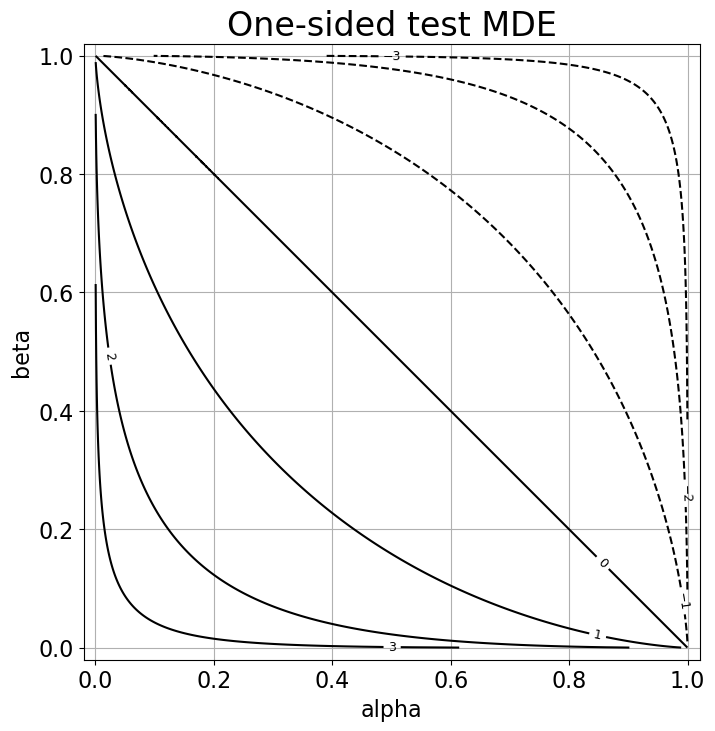

In [10]:
delta = .0005
dist = stats.norm(loc=0, scale=1)

x = np.arange(.0, 1., delta)
y = np.arange(.0, 1., delta)
X, Y = np.meshgrid(x, y)
MDE = dist.ppf(1 - X) + dist.ppf(1 - Y)

fig, ax = plt.subplots(figsize=(8, 8))
CS = ax.contour(X, Y, MDE, levels=np.arange(-3, 4), colors='k') # negative contour default to dashed.
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title('One-sided test MDE')
ax.set_aspect('equal')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_xlim(-.02, 1.02)
ax.set_ylim(-.02, 1.02)
ax.grid()

fig.savefig('one_sided_mde.png')

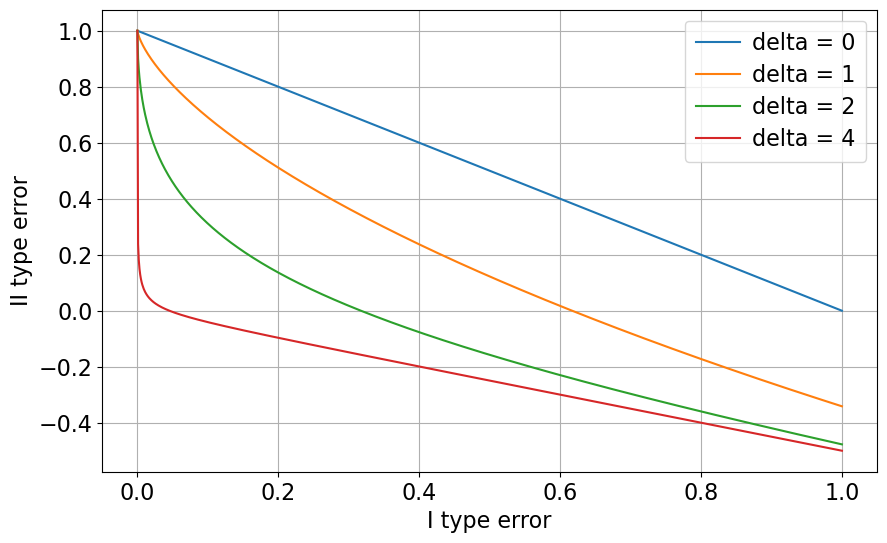

In [13]:
alpha = np.linspace(0, 1, 1001)

for h1_mean in [0, 1, 2, 4]:
    plt.plot(alpha, get_beta(alpha=alpha, H1_mean=h1_mean, two_side=True),
             label=f'delta = {h1_mean}')

plt.xlabel('I type error')
plt.ylabel('II type error')
plt.legend()

plt.grid()

In [14]:
def get_sample_size_abs(epsilon, std, alpha=.05, beta=.2):
    t_alpha = norm.ppf(norm.ppf(alpha /2, loc=0, scale=1))
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size
    

Часто нам интересно не абсолютное, а относительное изменение, эффект может быть посчитан как относительное увелчение
среднего значения. Пересчитаем минимальный размер в этих терминах.

In [16]:
def get_sample_size_arb(mu, std, eff=1.01, alpha=.05, beta=.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)


def check_ttest(a, b, alpha=.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

In [20]:
mu = 10
std = 1
eff = 1.01
alpha = .05
beta = .2

sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

print('Ошибки I и II рода')
for _ in range(10):
    result_aa = []
    result_ab = []
    for _ in range(10000):
        a_one = np.random.normal(mu, std, sample_size)
        a_two = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu * eff, std, sample_size)
        result_aa.append(check_ttest(a_one, a_two))
        result_ab.append(check_ttest(a_one, b))
    error_first = np.mean(result_aa)
    error_second = 1 - np.mean(result_ab)
    print(f'  {error_first:.3f} \t{error_second:.3f}')

sample_size = 1570

Ошибки I и II рода
  0.052 	0.197
  0.049 	0.203
  0.048 	0.195
  0.050 	0.200
  0.049 	0.198
  0.050 	0.204
  0.047 	0.191
  0.053 	0.203
  0.051 	0.204
  0.051 	0.197
